In [1]:

import xarray as xr

store = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/EOBS-feedstock/eobs-tg-tn-tx-rr-hu-pp.zarr'
ds = xr.open_dataset(store, engine='zarr', chunks={})


In [2]:
ds

<xarray.Dataset> Size: 306GB
Dimensions:    (time: 25933, latitude: 465, longitude: 705)
Coordinates:
  * time       (time) datetime64[ns] 207kB 1950-01-01 1950-01-02 ... 2020-12-31
  * latitude   (latitude) float64 4kB 25.05 25.15 25.25 ... 71.25 71.35 71.45
  * longitude  (longitude) float64 6kB -24.95 -24.85 -24.75 ... 45.35 45.45
Data variables:
    hu         (time, latitude, longitude) float32 34GB dask.array<chunksize=(40, 465, 705), meta=np.ndarray>
    pp         (time, latitude, longitude) float32 34GB dask.array<chunksize=(40, 465, 705), meta=np.ndarray>
    rr         (time, latitude, longitude) float32 34GB dask.array<chunksize=(40, 465, 705), meta=np.ndarray>
    tg         (time, latitude, longitude) float64 68GB dask.array<chunksize=(40, 465, 705), meta=np.ndarray>
    tn         (time, latitude, longitude) float64 68GB dask.array<chunksize=(40, 465, 705), meta=np.ndarray>
    tx         (time, latitude, longitude) float64 68GB dask.array<chunksize=(40, 465, 705), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 1.6.3 (http://c...
    CDO:                       Climate Data Operators version 1.6.3 (http://c...
    Conventions:               CF-1.4
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    history:                   Mon Sep  6 09:34:28 2021: ncap2 -O -4 -s where...
    nco_openmp_thread_number:  1
    pangeo-forge:inputs_hash:  ee8d7eaac44856a139b11abb3c3475cac42cfc8e049f9d...
    pangeo-forge:recipe_hash:  298aa637305d386ab8baa2da2b0664249770641089f5a2...
    pangeo-forge:version:      0.9.1

In [3]:
target_lat = 62.1
target_lon = 9.25

In [4]:
tg_norway = ds['tg'].sel(
    latitude=target_lat, 
    longitude=target_lon, 
    method='nearest'
).sel(time=slice('2002-01-01', '2020-12-31'))

In [5]:
tg_norway

<xarray.DataArray 'tg' (time: 6940)> Size: 56kB
dask.array<getitem, shape=(6940,), dtype=float64, chunksize=(40,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 56kB 2002-01-01 2002-01-02 ... 2020-12-31
    latitude   float64 8B 62.15
    longitude  float64 8B 9.25
Attributes:
    long_name:      mean temperature
    standard_name:  air_temperature
    units:          Celsius

In [7]:
monthly_mean_full = tg_norway.resample(time='1M').mean()

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [8]:
monthly_mean_full

<xarray.DataArray 'tg' (time: 228)> Size: 2kB
dask.array<groupby_nanmean, shape=(228,), dtype=float64, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
    latitude   float64 8B 62.15
    longitude  float64 8B 9.25
Attributes:
    long_name:      mean temperature
    standard_name:  air_temperature
    units:          Celsius

In [10]:

import xarray as xr

store = 'gs://leap-persistent-ro/data-library/feedstocks/metaflux_feedstock/meatflux_monthly.zarr'
ds = xr.open_dataset(store, engine='zarr', chunks={})


In [12]:
gpp_2002_2020 = ds.sel(time=slice('2002-01-01', '2020-12-31'))
lat_norway = 62.15
lon_norway = 9.25
norway_gpp = gpp_2002_2020.sel(
    latitude=lat_norway, 
    longitude=lon_norway, 
    method='nearest'
)


In [13]:
norway_reco = gpp_2002_2020.sel(
    latitude=lat_norway, 
    longitude=lon_norway, 
    method='nearest'
)['RECO']

norway_nee = norway_reco - norway_gpp.GPP

In [14]:
norway_nee

<xarray.DataArray (time: 228)> Size: 2kB
dask.array<sub, shape=(228,), dtype=float64, chunksize=(12,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2kB 2002-01-01 2002-02-01 ... 2020-12-01
    latitude   float32 4B 62.25
    longitude  float32 4B 9.25

In [15]:
monthly_gpp_total = norway_gpp.GPP * norway_gpp.time.dt.days_in_month
monthly_reco_total = norway_reco * norway_reco.time.dt.days_in_month
monthly_nee_total = monthly_reco_total - monthly_gpp_total

In [16]:
monthly_nee_total

<xarray.DataArray (time: 228)> Size: 2kB
dask.array<sub, shape=(228,), dtype=float64, chunksize=(12,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2kB 2002-01-01 2002-02-01 ... 2020-12-01
    latitude   float32 4B 62.25
    longitude  float32 4B 9.25

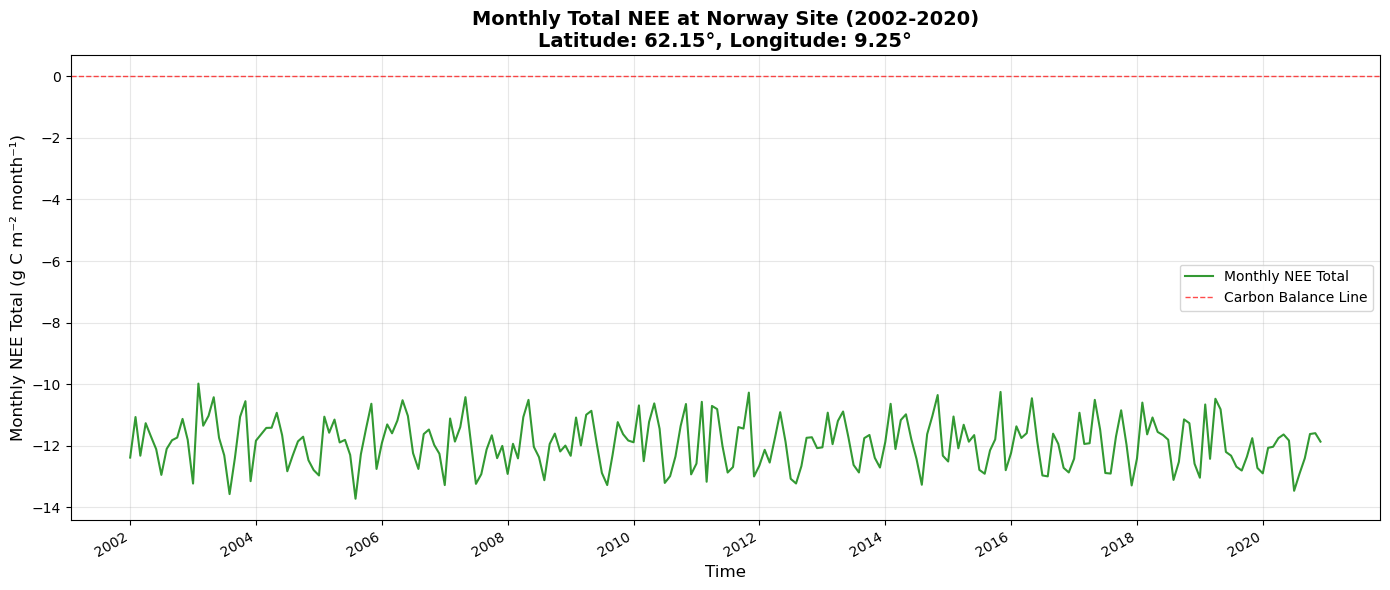

=== Monthly NEE Total Statistics ===
Time range: 2002-01-01T00:00:00.000000000 to 2020-12-01T00:00:00.000000000
Mean: -11.91 g C m⁻² month⁻¹
Range: [-13.73, -9.98] g C m⁻² month⁻¹
Standard deviation: 0.79 g C m⁻² month⁻¹


In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(monthly_nee_total.time.values, monthly_nee_total.values, 
         linewidth=1.5, color='green', alpha=0.8, label='Monthly NEE Total')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Carbon Balance Line')
plt.ylabel('Monthly NEE Total (g C m⁻² month⁻¹)', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.title(f'Monthly Total NEE at Norway Site (2002-2020)\nLatitude: {lat_norway}°, Longitude: {lon_norway}°', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


print("=== Monthly NEE Total Statistics ===")
print(f"Time range: {monthly_nee_total.time.min().values} to {monthly_nee_total.time.max().values}")
print(f"Mean: {monthly_nee_total.mean().values:.2f} g C m⁻² month⁻¹")
print(f"Range: [{monthly_nee_total.min().values:.2f}, {monthly_nee_total.max().values:.2f}] g C m⁻² month⁻¹")
print(f"Standard deviation: {monthly_nee_total.std().values:.2f} g C m⁻² month⁻¹")

r: -0.2162
R-squared (r²): 0.0467
P-value: 1.02e-03


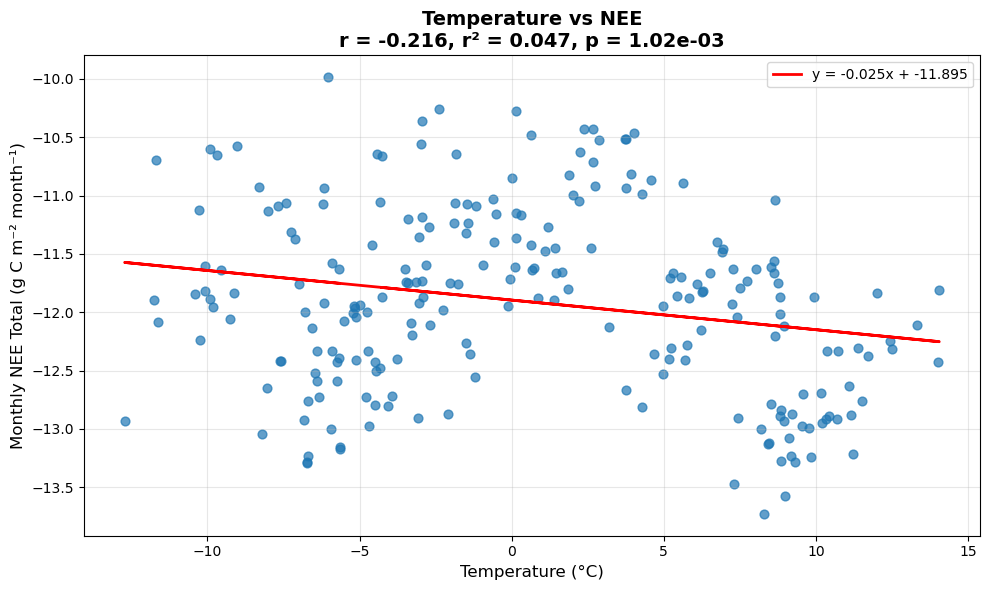

In [30]:
import numpy as np
from scipy import stats


temp_values = monthly_mean_full.values
nee_values = monthly_nee_total.values

correlation = np.corrcoef(temp_values, nee_values)[0, 1]
r_squared = correlation ** 2


corr_test = stats.pearsonr(temp_values, nee_values)

print(f"r: {correlation:.4f}")
print(f"R-squared (r²): {r_squared:.4f}")
print(f"P-value: {corr_test.pvalue:.2e}")

plt.figure(figsize=(10, 6))
plt.scatter(temp_values, nee_values, alpha=0.7, s=40)

z = np.polyfit(temp_values, nee_values, 1)
p = np.poly1d(z)
plt.plot(temp_values, p(temp_values), "r-", linewidth=2, 
         label=f'y = {z[0]:.3f}x + {z[1]:.3f}')

plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Monthly NEE Total (g C m⁻² month⁻¹)', fontsize=12)
plt.title(f'Temperature vs NEE\nr = {correlation:.3f}, r² = {r_squared:.3f}, p = {corr_test.pvalue:.2e}', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [36]:

import xarray as xr

store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-pipeline/MODIS_LAI/MODIS_LAI.zarr'
ds = xr.open_dataset(store, engine='zarr', chunks={})


In [37]:
ds

<xarray.Dataset> Size: 91GB
Dimensions:  (time: 874, lat: 3600, lon: 7200)
Coordinates:
  * time     (time) datetime64[ns] 7kB 2002-01-01 2002-01-09 ... 2020-12-26
  * lat      (lat) float32 14kB 89.97 89.93 89.88 89.82 ... -89.88 -89.93 -89.98
  * lon      (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    lai      (time, lat, lon) float32 91GB dask.array<chunksize=(100, 360, 720), meta=np.ndarray>
Attributes:
    citation:       [1] Lin, W., Yuan, H., Dai, Y. et al., 2022. Reprocessed ...
    contact:        Yuan, Hua (yuanh25@mail.sysu.edu.cn)
    creation_date:  20221119
    institution:    Land-Atmosphere Interaction Research Group at Sun Yat-sen...
    title:          LAI data sets for land surface and climate modelling

In [23]:
norway_lai = ds.sel(
    lat=lat_norway,
    lon=lon_norway, 
    method='nearest'
)

In [24]:
norway_lai

<xarray.Dataset> Size: 10kB
Dimensions:  (time: 874)
Coordinates:
  * time     (time) datetime64[ns] 7kB 2002-01-01 2002-01-09 ... 2020-12-26
    lat      float32 4B 62.17
    lon      float32 4B 9.225
Data variables:
    lai      (time) float32 3kB dask.array<chunksize=(100,), meta=np.ndarray>
Attributes:
    citation:       [1] Lin, W., Yuan, H., Dai, Y. et al., 2022. Reprocessed ...
    contact:        Yuan, Hua (yuanh25@mail.sysu.edu.cn)
    creation_date:  20221119
    institution:    Land-Atmosphere Interaction Research Group at Sun Yat-sen...
    title:          LAI data sets for land surface and climate modelling

In [26]:
lai= norway_lai.sel(time=slice('2002-01-01', '2020-12-31'))

In [28]:
monthly_lai = lai['lai'].resample(time='1M').mean()

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [29]:
monthly_lai

<xarray.DataArray 'lai' (time: 228)> Size: 912B
dask.array<groupby_nanmean, shape=(228,), dtype=float32, chunksize=(27,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
    lat      float32 4B 62.17
    lon      float32 4B 9.225
Attributes:
    long_name:  leaf area index
    units:      m2/m2

r: -0.4537
R-squared (r²): 0.2059
P-value: 5.61e-13


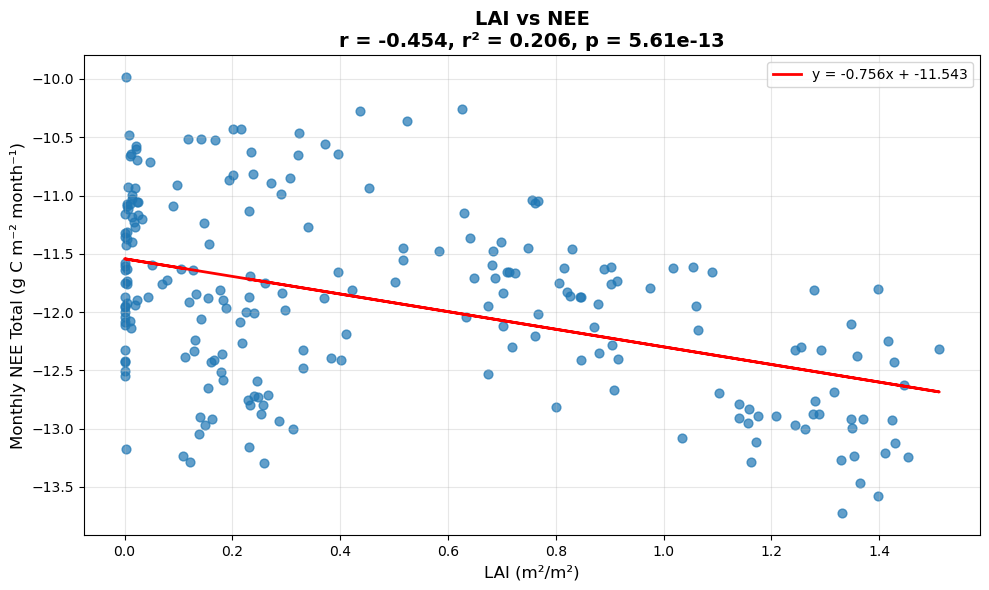

In [32]:
lai_values = monthly_lai.values
nee_values = monthly_nee_total.values

correlation = np.corrcoef(lai_values, nee_values)[0, 1]
r_squared = correlation ** 2


corr_test = stats.pearsonr(lai_values, nee_values)

print(f"r: {correlation:.4f}")
print(f"R-squared (r²): {r_squared:.4f}")
print(f"P-value: {corr_test.pvalue:.2e}")

plt.figure(figsize=(10, 6))
plt.scatter(lai_values, nee_values, alpha=0.7, s=40)

z = np.polyfit(lai_values, nee_values, 1)
p = np.poly1d(z)
plt.plot(lai_values, p(lai_values), "r-", linewidth=2, 
         label=f'y = {z[0]:.3f}x + {z[1]:.3f}')

plt.xlabel('LAI (m²/m²)', fontsize=12)
plt.ylabel('Monthly NEE Total (g C m⁻² month⁻¹)', fontsize=12)
plt.title(f'LAI vs NEE\nr = {correlation:.3f}, r² = {r_squared:.3f}, p = {corr_test.pvalue:.2e}', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [38]:

import xarray as xr

store = 'gs://leap-persistent/data-library/GPCP-daily/GPCP-daily.zarr'
ds = xr.open_dataset(store, engine='zarr', chunks={})


In [39]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:      (latitude: 180, nv: 2, longitude: 360, time: 10378)
Coordinates:
  * latitude     (latitude) float32 720B -90.0 -89.0 -88.0 ... 87.0 88.0 89.0
  * longitude    (longitude) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * time         (time) datetime64[ns] 83kB 1996-10-01 1996-10-02 ... 2025-02-28
Dimensions without coordinates: nv
Data variables:
    lat_bounds   (latitude, nv) float32 1kB dask.array<chunksize=(180, 2), meta=np.ndarray>
    lon_bounds   (longitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
    time_bounds  (time, nv) datetime64[ns] 166kB dask.array<chunksize=(400, 2), meta=np.ndarray>
    precip       (time, latitude, longitude) float32 3GB dask.array<chunksize=(400, 180, 360), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                CF-1.6, ACDD 1.3
    title:                      Global Precipitation Climatatology Project (G...
    source:                     /data1/GPCP_CDR/GPCP_Output/1DD//bin/199610/s...
    references:                 Huffman et al. 1997, http://dx.doi.org/10.117...
    history:                    1) 2017-05-30T16:52:42Z, Dr. Jian-Jian Wang, ...
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    ...                         ...
    metadata_link:              gov.noaa.ncdc:XXXXX
    product_version:            v01r03
    platform:                   GOES (Geostationary Operational Environmental...
    sensor:                     Imager, TOVS > TIROS Operational Vertical Sou...
    spatial_resolution:         1 degree
    comment:                    Processing computer: eagle2.umd.edu

In [40]:
norway_precip = ds.sel(
    latitude=lat_norway,
    longitude=lon_norway, 
    method='nearest'
)

In [41]:
norway_precip

<xarray.Dataset> Size: 291kB
Dimensions:      (nv: 2, time: 10378)
Coordinates:
  * time         (time) datetime64[ns] 83kB 1996-10-01 1996-10-02 ... 2025-02-28
    latitude     float32 4B 62.0
    longitude    float32 4B 9.0
Dimensions without coordinates: nv
Data variables:
    lat_bounds   (nv) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    lon_bounds   (nv) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    time_bounds  (time, nv) datetime64[ns] 166kB dask.array<chunksize=(400, 2), meta=np.ndarray>
    precip       (time) float32 42kB dask.array<chunksize=(400,), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                CF-1.6, ACDD 1.3
    title:                      Global Precipitation Climatatology Project (G...
    source:                     /data1/GPCP_CDR/GPCP_Output/1DD//bin/199610/s...
    references:                 Huffman et al. 1997, http://dx.doi.org/10.117...
    history:                    1) 2017-05-30T16:52:42Z, Dr. Jian-Jian Wang, ...
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    ...                         ...
    metadata_link:              gov.noaa.ncdc:XXXXX
    product_version:            v01r03
    platform:                   GOES (Geostationary Operational Environmental...
    sensor:                     Imager, TOVS > TIROS Operational Vertical Sou...
    spatial_resolution:         1 degree
    comment:                    Processing computer: eagle2.umd.edu

In [42]:
precip_2002_2020 = norway_precip.sel(time=slice('2002-01-01', '2020-12-31'))
monthly_precip = precip_2002_2020['precip'].resample(time='1M').sum()

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


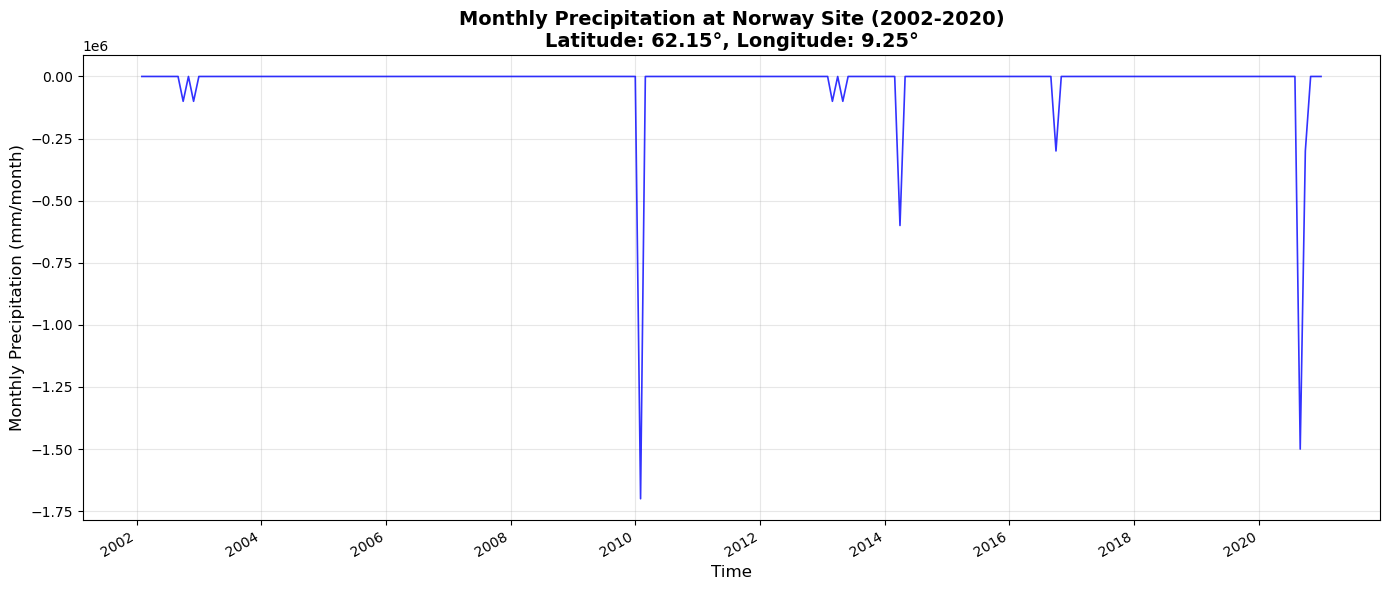

In [45]:
import matplotlib.pyplot as plt

# 绘制月度降雨量图
plt.figure(figsize=(14, 6))
plt.plot(monthly_precip.time.values, monthly_precip.values, 
         linewidth=1.2, color='blue', alpha=0.8)

plt.ylabel('Monthly Precipitation (mm/month)', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.title(f'Monthly Precipitation at Norway Site (2002-2020)\nLatitude: {lat_norway}°, Longitude: {lon_norway}°', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 自动调整日期显示
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

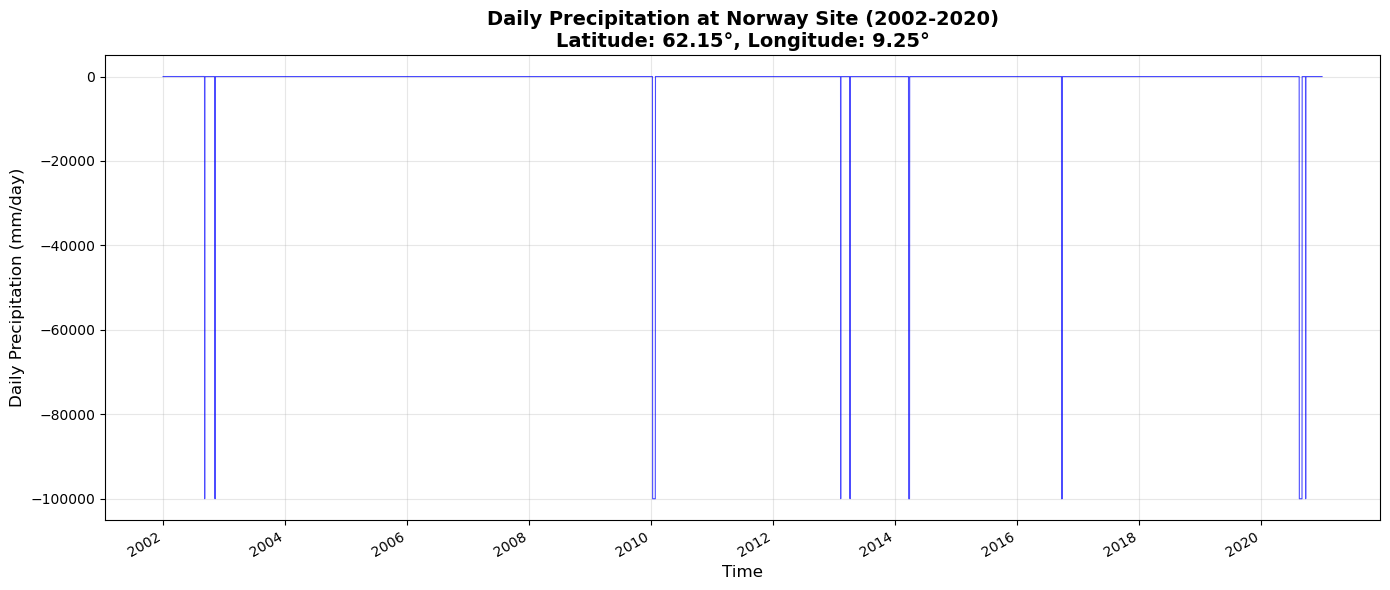

=== 日降雨量统计 ===
时间范围: 2002-01-01T00:00:00.000000000 到 2020-12-31T00:00:00.000000000
数据点数: 6940
日均降雨量: -689.19 mm/day
日降雨量范围: [-99999.00, 26.18] mm/day


In [46]:
import matplotlib.pyplot as plt

# 绘制日降雨量图
plt.figure(figsize=(14, 6))
plt.plot(precip_2002_2020.time.values, precip_2002_2020.precip.values, 
         linewidth=0.8, color='blue', alpha=0.7)

plt.ylabel('Daily Precipitation (mm/day)', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.title(f'Daily Precipitation at Norway Site (2002-2020)\nLatitude: {lat_norway}°, Longitude: {lon_norway}°', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 自动调整日期显示
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# 打印日降雨量统计
print("=== 日降雨量统计 ===")
print(f"时间范围: {precip_2002_2020.time.min().values} 到 {precip_2002_2020.time.max().values}")
print(f"数据点数: {len(precip_2002_2020.time)}")
print(f"日均降雨量: {precip_2002_2020.precip.mean().values:.2f} mm/day")
print(f"日降雨量范围: [{precip_2002_2020.precip.min().values:.2f}, {precip_2002_2020.precip.max().values:.2f}] mm/day")

In [47]:
# 查看数据的基本信息
print("=== 降雨数据详细信息 ===")
print(precip_2002_2020)

print("\n=== 数据变量信息 ===")
print(f"变量名: {list(precip_2002_2020.data_vars.keys())}")
print(f"数据形状: {precip_2002_2020.precip.shape}")

print("\n=== 数据统计 ===")
print(f"最小值: {precip_2002_2020.precip.min().values}")
print(f"最大值: {precip_2002_2020.precip.max().values}")
print(f"均值: {precip_2002_2020.precip.mean().values}")
print(f"标准差: {precip_2002_2020.precip.std().values}")

print("\n=== 前20个数据点 ===")
print(precip_2002_2020.precip.isel(time=slice(0, 20)).values)

print("\n=== 后20个数据点 ===")
print(precip_2002_2020.precip.isel(time=slice(-20, None)).values)

print("\n=== 零值统计 ===")
zero_count = (precip_2002_2020.precip == 0).sum().values
total_count = len(precip_2002_2020.time)
print(f"零值数量: {zero_count}/{total_count} ({zero_count/total_count*100:.1f}%)")

=== 降雨数据详细信息 ===
<xarray.Dataset> Size: 194kB
Dimensions:      (nv: 2, time: 6940)
Coordinates:
  * time         (time) datetime64[ns] 56kB 2002-01-01 2002-01-02 ... 2020-12-31
    latitude     float32 4B 62.0
    longitude    float32 4B 9.0
Dimensions without coordinates: nv
Data variables:
    lat_bounds   (nv) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    lon_bounds   (nv) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    time_bounds  (time, nv) datetime64[ns] 111kB dask.array<chunksize=(82, 2), meta=np.ndarray>
    precip       (time) float32 28kB dask.array<chunksize=(82,), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                CF-1.6, ACDD 1.3
    title:                      Global Precipitation Climatatology Project (G...
    source:                     /data1/GPCP_CDR/GPCP_Output/1DD//bin/199610/s...
    references:                 Huffman et al. 1997, http://dx.doi.org/10.117...
    history:                    1) 2017-05-30T16:52:42Z, Dr. Ji

In [49]:
# 查看月度降雨数据
print("=== 月度降雨数据详细信息 ===")
print(monthly_precip)

print("\n=== 月度降雨数据统计 ===")
print(f"数据点数: {len(monthly_precip.time)}")
print(f"时间范围: {monthly_precip.time.min().values} 到 {monthly_precip.time.max().values}")
print(f"最小值: {monthly_precip.min().values:.2f} mm")
print(f"最大值: {monthly_precip.max().values:.2f} mm")
print(f"均值: {monthly_precip.mean().values:.2f} mm")
print(f"标准差: {monthly_precip.std().values:.2f} mm")

print("\n=== 前12个月的数据 ===")
for i in range(12):
    date = monthly_precip.time.isel(time=i).values
    value = monthly_precip.isel(time=i).values
    print(f"{date}: {value:.2f} mm")

print("\n=== 后12个月的数据 ===")
for i in range(-12, 0):
    date = monthly_precip.time.isel(time=i).values
    value = monthly_precip.isel(time=i).values
    print(f"{date}: {value:.2f} mm")

print("\n=== 年度统计 ===")
# 按年份分组统计
yearly_precip = monthly_precip.groupby('time.year').sum()
for year in yearly_precip.year.values[:5]:  # 显示前5年
    value = yearly_precip.sel(year=year).values
    print(f"{year}: {value:.1f} mm")

=== 月度降雨数据详细信息 ===
<xarray.DataArray 'precip' (time: 228)> Size: 912B
dask.array<groupby_nansum, shape=(228,), dtype=float32, chunksize=(14,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
    latitude   float32 4B 62.0
    longitude  float32 4B 9.0
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of Daily GPCP Satellite-Ga...
    standard_name:  lwe_precipitation_rate
    units:          mm/day
    valid_range:    [0.0, 100.0]
    cell_methods:   area: mean time: mean

=== 月度降雨数据统计 ===
数据点数: 228
时间范围: 2002-01-31T00:00:00.000000000 到 2020-12-31T00:00:00.000000000
最小值: -1699969.38 mm
最大值: 157.02 mm
均值: -20977.95 mm
标准差: 156989.55 mm

=== 前12个月的数据 ===
2002-01-31T00:00:00.000000000: 106.82 mm
2002-02-28T00:00:00.000000000: 126.97 mm
2002-03-31T00:00:00.000000000: 95.27 mm
2002-04-30T00:00:00.000000000: 37.68 mm
2002-05-31T00:00:00.000000000: 68.36 mm
2002-06-30T00:00:00.000000000: 94.07 mm
2002-07-31T00:00

In [50]:
# 在日数据层面处理异常值
print("=== 处理日降雨数据异常值 ===")

# 检查日数据的异常值
daily_precip = precip_2002_2020.precip
print(f"日数据范围: [{daily_precip.min().values:.2f}, {daily_precip.max().values:.2f}] mm/天")

# 识别异常值（负值和极端正值）
# 挪威日降雨量超过100mm基本不可能
valid_mask = (daily_precip >= 0) & (daily_precip <= 100)
invalid_count = ((daily_precip < 0) | (daily_precip > 100)).sum().values
print(f"日数据异常值数量: {invalid_count}/{len(daily_precip)}")

=== 处理日降雨数据异常值 ===
日数据范围: [-99999.00, 26.18] mm/天
日数据异常值数量: 48/6940


In [53]:
# 只处理负值异常数据
print("=== 只处理负值异常 ===")

daily_precip = precip_2002_2020.precip

# 先加载数据到内存
daily_precip_loaded = daily_precip.load()

# 统计负值数量
negative_count = (daily_precip_loaded < 0).sum().values
total_count = len(daily_precip_loaded)

print(f"负值数量: {negative_count}/{total_count} ({negative_count/total_count*100:.2f}%)")

# 查看负值的具体数值
print(f"\n=== 负值样本查看 ===")
negative_mask = daily_precip_loaded < 0
negative_indices = np.where(negative_mask)[0]

if len(negative_indices) > 0:
    print("前10个负值:")
    for i in range(min(10, len(negative_indices))):
        idx = negative_indices[i]
        date = daily_precip_loaded.time.isel(time=idx).values
        value = daily_precip_loaded.isel(time=idx).values
        print(f"  {date}: {value:.2f} mm")

=== 只处理负值异常 ===
负值数量: 48/6940 (0.69%)

=== 负值样本查看 ===
前10个负值:
  2002-09-07T00:00:00.000000000: -99999.00 mm
  2002-11-08T00:00:00.000000000: -99999.00 mm
  2010-01-10T00:00:00.000000000: -99999.00 mm
  2010-01-11T00:00:00.000000000: -99999.00 mm
  2010-01-12T00:00:00.000000000: -99999.00 mm
  2010-01-13T00:00:00.000000000: -99999.00 mm
  2010-01-14T00:00:00.000000000: -99999.00 mm
  2010-01-15T00:00:00.000000000: -99999.00 mm
  2010-01-16T00:00:00.000000000: -99999.00 mm
  2010-01-17T00:00:00.000000000: -99999.00 mm


In [54]:
clean_daily_precip = daily_precip_loaded.where(daily_precip_loaded >= 0)

print(f"\n=== 处理后的日数据统计 ===")
print(f"有效数据点数: {clean_daily_precip.count().values}/{total_count}")
print(f"数据范围: [{clean_daily_precip.min().values:.2f}, {clean_daily_precip.max().values:.2f}] mm/天")
print(f"日均降雨量: {clean_daily_precip.mean().values:.2f} mm/天")


=== 处理后的日数据统计 ===
有效数据点数: 6892/6940
数据范围: [0.00, 26.18] mm/天
日均降雨量: 2.46 mm/天


In [55]:
monthly_precip_clean = clean_daily_precip.resample(time='1M').sum()

print(f"\n=== 清理后的月度数据 ===")
print(f"月度数据范围: [{monthly_precip_clean.min().values:.2f}, {monthly_precip_clean.max().values:.2f}] mm/月")
print(f"月均降雨量: {monthly_precip_clean.mean().values:.2f} mm/月")


=== 清理后的月度数据 ===
月度数据范围: [10.38, 157.02] mm/月
月均降雨量: 74.47 mm/月


/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [56]:
print(f"\n=== 清理后的月度数据前12个月 ===")
for i in range(12):
    date = monthly_precip_clean.time.isel(time=i).values
    value = monthly_precip_clean.isel(time=i).values
    print(f"{date}: {value:.2f} mm")


=== 清理后的月度数据前12个月 ===
2002-01-31T00:00:00.000000000: 106.82 mm
2002-02-28T00:00:00.000000000: 126.97 mm
2002-03-31T00:00:00.000000000: 95.27 mm
2002-04-30T00:00:00.000000000: 37.68 mm
2002-05-31T00:00:00.000000000: 68.36 mm
2002-06-30T00:00:00.000000000: 94.07 mm
2002-07-31T00:00:00.000000000: 92.69 mm
2002-08-31T00:00:00.000000000: 57.66 mm
2002-09-30T00:00:00.000000000: 106.82 mm
2002-10-31T00:00:00.000000000: 80.29 mm
2002-11-30T00:00:00.000000000: 54.04 mm
2002-12-31T00:00:00.000000000: 30.75 mm


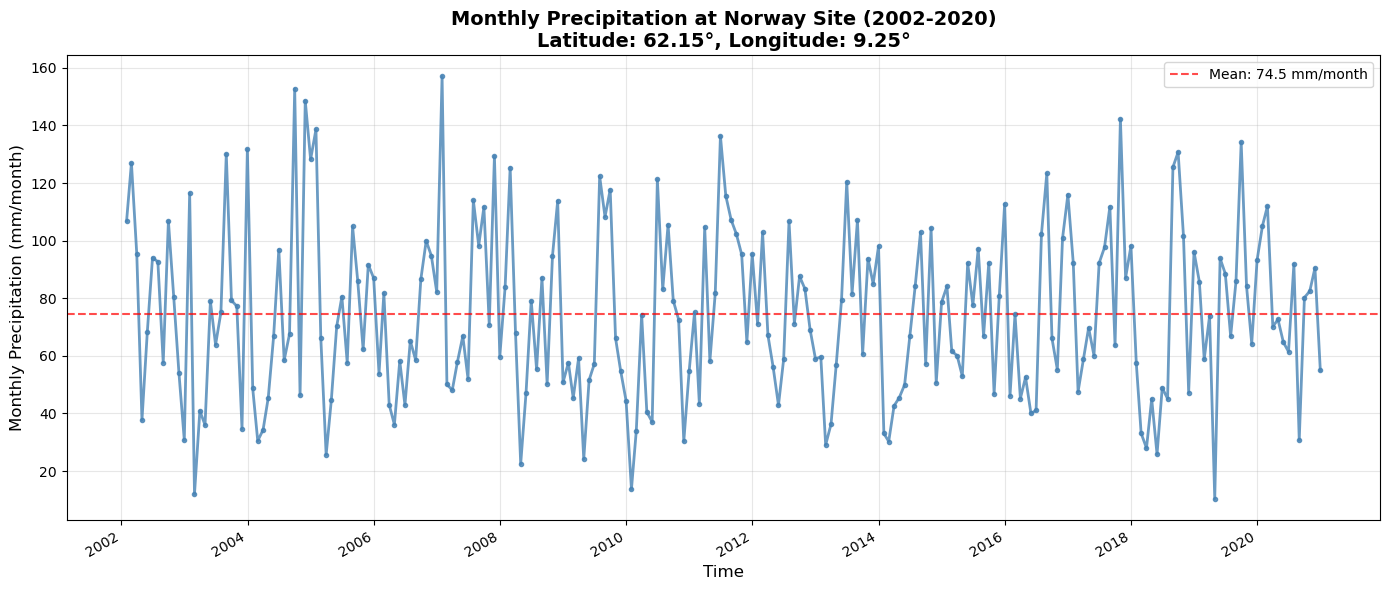

=== 月度降雨数据统计 ===
时间范围: 2002-01-31T00:00:00.000000000 到 2020-12-31T00:00:00.000000000
数据点数: 228
平均月降雨量: 74.5 mm
月降雨量范围: [10.4, 157.0] mm
年降雨量估算: 894 mm/year


In [57]:
import matplotlib.pyplot as plt

# 绘制清理后的月度降雨数据
plt.figure(figsize=(14, 6))
plt.plot(monthly_precip_clean.time.values, monthly_precip_clean.values, 
         linewidth=2, color='steelblue', alpha=0.8, marker='o', markersize=3)

plt.ylabel('Monthly Precipitation (mm/month)', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.title(f'Monthly Precipitation at Norway Site (2002-2020)\nLatitude: {lat_norway}°, Longitude: {lon_norway}°', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 添加平均值线
mean_precip = monthly_precip_clean.mean().values
plt.axhline(y=mean_precip, color='red', linestyle='--', alpha=0.7, 
            label=f'Mean: {mean_precip:.1f} mm/month')

plt.legend()
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# 打印统计信息
print("=== 月度降雨数据统计 ===")
print(f"时间范围: {monthly_precip_clean.time.min().values} 到 {monthly_precip_clean.time.max().values}")
print(f"数据点数: {len(monthly_precip_clean.time)}")
print(f"平均月降雨量: {monthly_precip_clean.mean().values:.1f} mm")
print(f"月降雨量范围: [{monthly_precip_clean.min().values:.1f}, {monthly_precip_clean.max().values:.1f}] mm")
print(f"年降雨量估算: {monthly_precip_clean.mean().values * 12:.0f} mm/year")

r: -0.5355
R-squared (r²): 0.2868
P-value: 2.55e-18


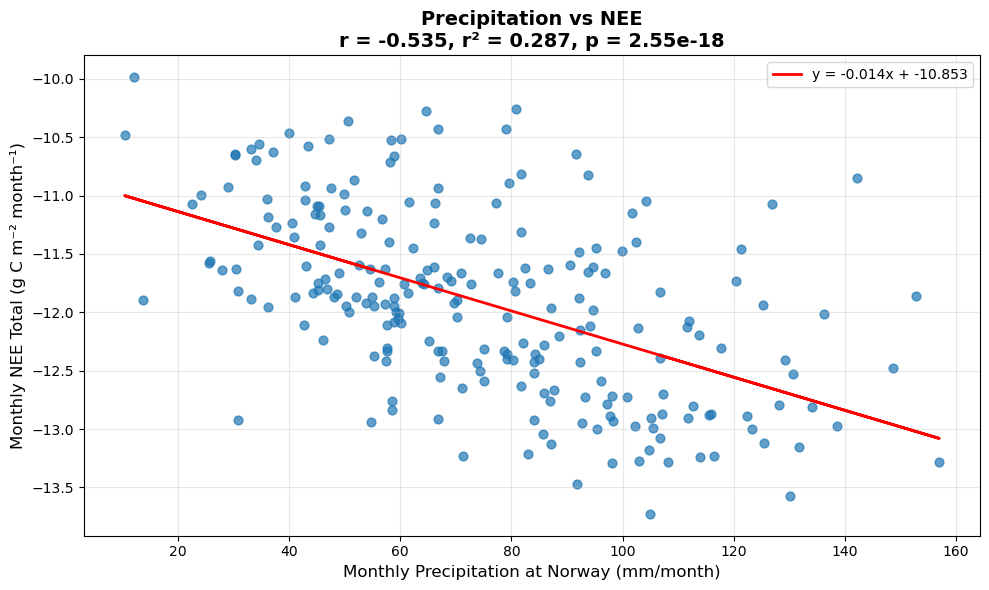

In [58]:
pre_values = monthly_precip_clean.values
nee_values = monthly_nee_total.values

correlation = np.corrcoef(pre_values, nee_values)[0, 1]
r_squared = correlation ** 2


corr_test = stats.pearsonr(pre_values, nee_values)

print(f"r: {correlation:.4f}")
print(f"R-squared (r²): {r_squared:.4f}")
print(f"P-value: {corr_test.pvalue:.2e}")

plt.figure(figsize=(10, 6))
plt.scatter(pre_values, nee_values, alpha=0.7, s=40)

z = np.polyfit(pre_values, nee_values, 1)
p = np.poly1d(z)
plt.plot(pre_values, p(pre_values), "r-", linewidth=2, 
         label=f'y = {z[0]:.3f}x + {z[1]:.3f}')

plt.xlabel('Monthly Precipitation at Norway (mm/month)', fontsize=12)
plt.ylabel('Monthly NEE Total (g C m⁻² month⁻¹)', fontsize=12)
plt.title(f'Precipitation vs NEE\nr = {correlation:.3f}, r² = {r_squared:.3f}, p = {corr_test.pvalue:.2e}', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [60]:
import pandas as pd

# 创建包含所有特征的DataFrame
ml_data = pd.DataFrame({
    'time': monthly_precip_clean.time.values,
    'temperature': monthly_mean_full.values,
    'lai': monthly_lai.values,
    'precipitation': monthly_precip_clean.values,
    'nee': monthly_nee_total.values  # 目标变量
})

print("=== 整合后的数据 ===")
print(ml_data.head())
print(f"数据形状: {ml_data.shape}")

=== 整合后的数据 ===
        time  temperature       lai  precipitation        nee
0 2002-01-31    -5.661290  0.111640     106.822304 -12.389620
1 2002-02-28    -6.188571  0.005210     126.971954 -11.071642
2 2002-03-31    -4.732258  0.000000      95.268974 -12.328427
3 2002-04-30     1.192667  0.020144      37.684628 -11.272329
4 2002-05-31     5.573548  0.233350      68.357285 -11.693965
数据形状: (228, 5)
